In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

# Initial setup 

In [3]:
mpl.rcParams["image.cmap"] = "gray"

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [7]:
model = Model(m, nh, 10)

In [8]:
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [9]:
def log_softmax(x):
    # broadcast denom
    return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [10]:
pred.sum(-1, keepdim=True).shape

torch.Size([50000, 1])

In [11]:
sm_pred = log_softmax(pred)
sm_pred.shape

torch.Size([50000, 10])

In [12]:
y_train[:3]

tensor([5, 0, 4])

In [13]:
sm_pred[[0, 1,2], [5, 0, 4]]

tensor([-2.1828, -2.4415, -2.1657], grad_fn=<IndexBackward>)

In [14]:
y_train.shape[0]

50000

In [15]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [16]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3129, grad_fn=<NegBackward>)

In [17]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [18]:
test_near(nll(log_softmax(pred), y_train), loss)

In [19]:
pred.max(-1)[0].shape

torch.Size([50000])

In [20]:
def logsumexp(x):
    m = x.max(-1)[0] # get values
    return m + (x-m[:,None]).exp().sum(-1).log()

In [21]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [22]:
pred.logsumexp??

In [23]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [24]:
test_near(nll(log_softmax(pred), y_train), loss)

In [25]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [26]:
test_near(F.cross_entropy(pred, y_train), loss)

In [27]:
??F.log_softmax

In [28]:
??F.nll_loss

In [29]:
??F.cross_entropy

# Basic training loop 

In [30]:
loss_func = F.cross_entropy

In [31]:
#export
def accuracy(out, yb):
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [32]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.0679,  0.1871, -0.2074,  0.0209,  0.0186,  0.1120, -0.3012,  0.0745,
         -0.1203,  0.1018], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [33]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.2980, grad_fn=<NllLossBackward>)

In [34]:
accuracy(preds, yb)

tensor(0.1719)

In [35]:
lr = 0.5
epochs  =1

In [36]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, "weight"):
                    l.weight -= l.weight.grad *lr
                    l.bias   -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [37]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0280, grad_fn=<NllLossBackward>), tensor(1.))

# Using parameters and optim 

In [38]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [39]:
model = Model(m, nh, 10)

In [40]:
for name, l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [41]:
model.__repr__

<bound method Module.__repr__ of Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)>

In [42]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [43]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [44]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [45]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1377, grad_fn=<NllLossBackward>), tensor(0.9375))

In [46]:
class DummyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f"{self._modules}"
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [47]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [48]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registerin modules 

In [49]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [50]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [51]:
model = Model(layers)

In [52]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [53]:
class SequentialModel(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [54]:
model = SequentialModel(layers)

In [55]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [56]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0942, grad_fn=<NllLossBackward>), tensor(1.))

In [57]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [58]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0705, grad_fn=<NllLossBackward>), tensor(1.))

In [59]:
nn.Sequential??

In [60]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [61]:
for ob in model.parameters():
    print(ob.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## optim 

In [62]:
class Optimizer:
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
                
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [63]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [64]:
opt = Optimizer(model.parameters())

In [65]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [66]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

In [67]:
loss, acc

(tensor(0.0727, grad_fn=<NllLossBackward>), tensor(1.))

In [68]:
#export
from torch import optim

In [69]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [70]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.3023, grad_fn=<NllLossBackward>)

In [71]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [72]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.2310, grad_fn=<NllLossBackward>), tensor(0.9375))

# Dataset and DataLoader 

In [73]:
#export
class Dataset:
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [74]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [75]:
xb, yb = train_ds[0:5]
assert xb.shape == (5,28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [76]:
model, opt = get_model()

In [77]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs : i*bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [78]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0203, grad_fn=<NllLossBackward>), tensor(1.))

## DataLoader 

In [79]:
class DataLoader:
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [80]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [81]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28*28)
assert yb.shape == (bs,)

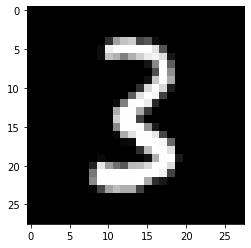

In [82]:
plt.imshow(xb[0].view(28,28))

In [83]:
model, opt = get_model()

In [84]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [85]:
fit()

In [86]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1715, grad_fn=<NllLossBackward>), tensor(0.9375))

## Random Sampling 

In [89]:
class Sampler:
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0,self.n, self.bs): yield self.idxs[i:i+self.bs]

In [93]:
small_ds = Dataset(*train_ds[:10])

In [95]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [98]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([4, 8, 0]), tensor([5, 1, 9]), tensor([3, 6, 2]), tensor([7])]

In [126]:
def collate(b):
    # regroup elements
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader:
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [127]:
x1, x2 = zip(*[(0,2), (1, 3)])
x1, x2

((0, 1), (2, 3))

In [130]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [131]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

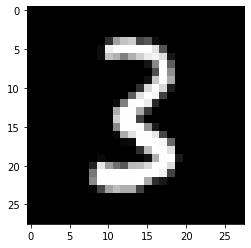

In [136]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(3)

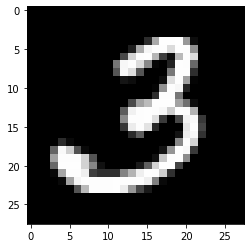

In [137]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

tensor(5)

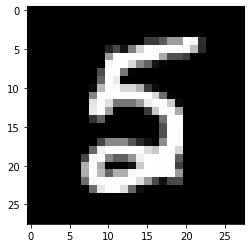

In [138]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [139]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.3069, grad_fn=<NllLossBackward>), tensor(0.8750))

In [140]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [141]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [142]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2985, grad_fn=<NllLossBackward>), tensor(0.8438))

In [143]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [145]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0762, grad_fn=<NllLossBackward>), tensor(0.9844))

## Validation 

In [153]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [154]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [155]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1783) tensor(0.9469)
1 tensor(0.1682) tensor(0.9475)
2 tensor(0.6457) tensor(0.8560)
3 tensor(0.1302) tensor(0.9612)
4 tensor(0.1072) tensor(0.9704)


In [157]:
assert acc > 0.9

# Export 

In [158]:
!python %notebook 03_minibatch_training.ipynb 

python: can't open file '%notebook': [Errno 2] No such file or directory
